# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of Structure-Based Virtual Screening (SBVS), molecular descriptors and machine learning techniques for identifying active and inactive compounds given a SARS-CoV-2 assay. [Postera.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

Each model was constructed with a Pipeline of SMOTE and StandardScaler, which were used for rebalancing and scaling the data, respectively. Then, StratifiedKFold was used for training and cross-validating the model. Finally, roc_auc_score, geometric_mean_score and f2_score were used as metrics for choosing the best set of descriptors for each model (XGBClassifier, RandomForestClassifier, etc.). 

The best model was KNeighborsClassifier, which had the highest early recognition according to its ROC curve, followed by LinearDiscriminantAnalysis, LinearSVC and LogisticRegression, which produced similar results. XGBClassifier, DecisionTreeClassifier and RandomForestClassifier had the lowest roc_auc_score, though all models outperformed the models that considered only the docking scores. 

## Results
The results are presented in [this separate notebook](https://github.com/caiocrocha/COVID-19/blob/master/SARS-CoV-2/postera.ai/ML_results.ipynb).

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

0. [Imports](#imports)    
1. [Reading data](#reading_data)    
    1. [Activity data](#activity_data)    
    2. [Read molecular descriptors](#read_descriptors)
    3. [Read docking results](#read_docking)    
2. [Machine learning](#machine_learning)     
    1. [Constructing the models](#constructing)     
    2. [Scoring metrics](#scoring_metrics)     
    3. [Running the models](#running)    
4. [Supplementary data](#supplementary)   
    1. [Regression plots](#regression)    
    2. [QQ Plot](#qq_plot)    
    3. [Correlations](#correlations)        

<a id='imports'></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

import multiprocessing
from functools import partial
import itertools
import time
import os
import subprocess

<a id='reading_data'></a>
## Reading data
<a id='activity_data'></a>
### Activity data

,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69973
f_inhibition_at_50_uM,0.69973,1.00000


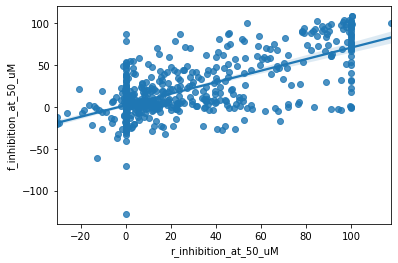

In [2]:
def write_data():
    import requests
    
    url = 'https://covid.postera.ai/covid/activity_data.csv'
    r = requests.get(url, allow_redirects=True)

    with open('activity_data.csv', 'wb') as f:
        f.write(r.content)
        
## Fetch activity data
#write_data()

# Read activity data
activity = pd.read_csv('activity_data.csv')

# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(x=activity['r_inhibition_at_50_uM'], y=activity['f_inhibition_at_50_uM'])
activity[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

<a id='read_descriptors'></a>
### Read molecular descriptors

In [3]:
def rdkit_2d_coordinates(activity):
    from rdkit import Chem
    # Write into smiles
    activity[['SMILES','CID']].to_csv('smiles.smi', sep=' ', index=False, header=None)
    suppl = Chem.SmilesMolSupplier('smiles.smi')
    # Compute 2D coordinates
    coordinates = [x for x in suppl if x is not None]
    return coordinates

def write_rdkit_descriptors(coordinates, descriptors_list, csv):
    from rdkit.Chem import Descriptors
    # Create dict of callable descriptors
    descriptors_dict = {}
    for name in descriptors_list:
        try:
             descriptor = eval(f'Descriptors.{name}')
        except AttributeError as e:
            # Skip descriptor if it doesn't exist
            print(f'No module named Descriptors.{name}')
            continue
        
        descriptors_dict[name] = descriptor
    
    # Check if descriptors_dict is empty
    if not bool(descriptors_dict):
        print('No descriptor to calculate')
        return
    
    list_all = []
    # Call descriptors for each molecule
    for mol in coordinates:
        d = {'CID': mol.GetProp('_Name')}
        for name, descriptor in descriptors_dict.items():
            try:
                d[name] = descriptor(mol)
            except Exception as e:
                print('Exception found, exiting function')
                print(str(e))
                return
        
        list_all.append(d)
    
    descriptors = pd.DataFrame(list_all)
    descriptors.to_csv(csv, index=False)

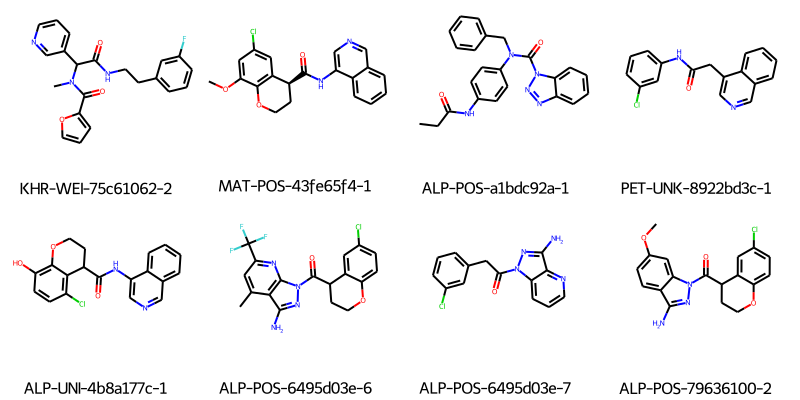

In [4]:
csv_descriptors = 'descriptors.csv'
coordinates = rdkit_2d_coordinates(activity)

# Write RDKit descriptors
rdkit_descriptors = ['MolMR','NumRotatableBonds','NumHAcceptors','NumHDonors','TPSA','LabuteASA','MolLogP']
write_rdkit_descriptors(coordinates, rdkit_descriptors, csv=csv_descriptors)

# Read descriptors
descriptors = pd.read_csv(csv_descriptors)

# Draw
from rdkit.Chem import Draw
Draw.MolsToGridImage(coordinates[:8],
        molsPerRow=4,
        subImgSize=(200,200),
        legends=[x.GetProp("_Name") for x in coordinates[:8]])

<a id='read_docking'></a>
### Read docking results

In [5]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)

# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)

# Merge top scores and experimental data
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, activity[['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']])
del tmp

# Merge descriptors to "top"
data = pd.merge(descriptors, top)

# Label actives and inactives in relation to "RapidFire"
data['r_active'] = data['r_inhibition_at_50_uM'] > 50
data['r_active'] = data['r_active'].astype(int) # 1 for active, 0 for inactive

# Label actives and inactives in relation to the fluorescence assay
data['f_active'] = data['f_inhibition_at_50_uM'] > 50
data['f_active'] = data['f_active'].astype(int) # 1 for active, 0 for inactive

data.to_csv('data.csv')
data.head()

,CID,MolMR,NumRotatableBonds,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,f_inhibition_at_50_uM,r_active,f_active
0,MAT-POS-02ae579f-1,142.9562,8,3,1,62.55,216.479769,6.4632,-7.7,7.746907,-93.0745,7.544520,NaN,0.007703,0,0
1,MAT-POS-02ae579f-2,73.8221,2,3,3,82.70,115.581247,1.5105,-7.2,6.285345,-80.1747,6.407342,NaN,2.287651,0,0
2,LOR-NOR-f9b26152-1,45.9122,1,3,1,55.40,78.672385,0.9691,-5.5,4.929599,-59.7841,5.100658,7.794489,3.016446,0,0
3,LON-WEI-2e27a2e5-2,146.2802,8,4,1,75.19,222.124736,5.6602,-7.3,7.575922,-97.6586,7.776974,NaN,-6.337255,0,0
4,MAT-POS-af71705c-1,86.0674,2,4,2,76.02,125.972082,2.5775,-6.2,6.609277,-54.8444,6.834465,0.000000,-0.727192,0,0


Text(0.5, 0.98, 'Class distribution')

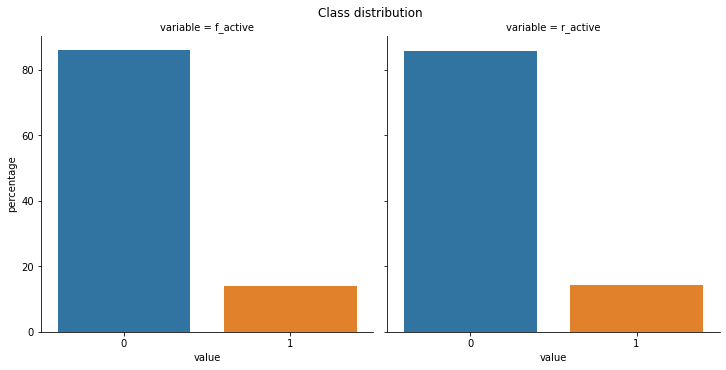

In [6]:
# Descriptors
descriptors_list = list(descriptors.columns[1:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']

trainset = descriptors_list + docking_list
data.dropna(subset=trainset, inplace=True)

tmp = pd.melt(data, id_vars=['CID'], value_vars=['r_active','f_active'])
tmp2 = (tmp.groupby(['variable'])['value'].value_counts(
    normalize=True).rename('percentage').mul(100).reset_index().sort_values('value'))
g = sns.catplot(data=tmp2, kind='bar', x='value', y='percentage', col='variable')
del tmp, tmp2
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Class distribution')

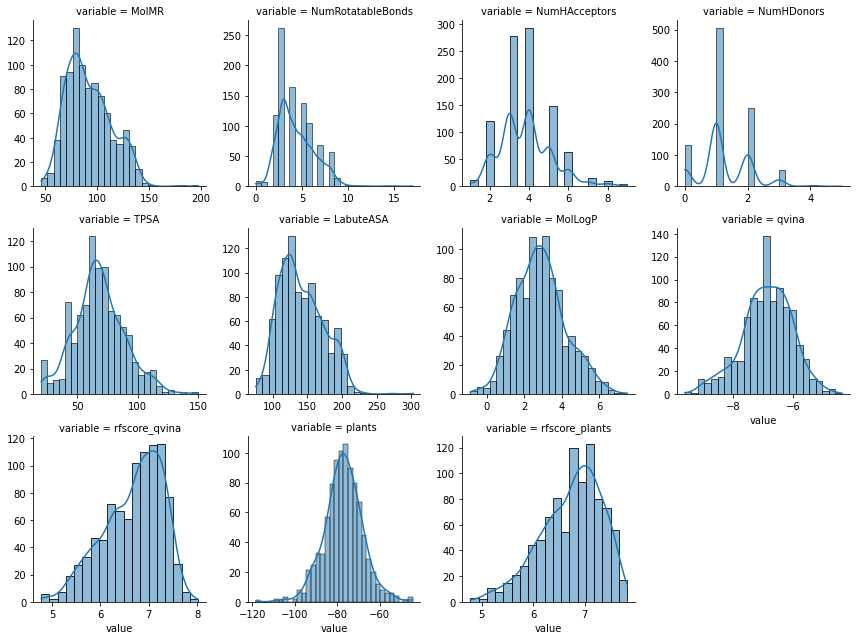

In [7]:
tmp = pd.melt(data, id_vars=['CID'], value_vars=trainset)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)

<a id='machine_learning'></a>
## Machine learning
<a id='constructing'></a>
### Constructing the models

The data is approximately normaly distributed, and can be standardized. However, some descriptors present skewness and the QQ-Plot shows the outermost data has greater variance, which could indicate heteroskedacity (non-constant variance). 

In [19]:
class MyClass:
    @staticmethod
    def get_model_names():
        return ['LogisticRegression','RandomForestClassifier','KNeighborsClassifier',
            'LinearSVC','XGBClassifier', 'DecisionTreeClassifier', 'LinearDiscriminantAnalysis']

    @staticmethod
    def get_model_by_name(model_name):
        if model_name == 'LogisticRegression':
            return LogisticRegression(solver='liblinear', random_state=13)
        elif model_name == 'LinearSVC':
            return CalibratedClassifierCV(LinearSVC(dual=False, random_state=13))
        elif model_name == 'RandomForestClassifier':
            return RandomForestClassifier(n_estimators=40, max_depth=6, random_state=13)
        elif model_name == 'KNeighborsClassifier':
            return KNeighborsClassifier(n_neighbors=5)
        elif model_name == 'XGBClassifier':
            return XGBClassifier(objective='reg:logistic', n_estimators=40, max_depth=3, eta=0.2, random_state=13)
        elif model_name == 'DecisionTreeClassifier':
            return DecisionTreeClassifier(max_depth=6, random_state=13)
        elif model_name == 'LinearDiscriminantAnalysis':
            return LinearDiscriminantAnalysis(solver='svd')
        return None

    @staticmethod
    def get_scores_list(X_train, X_test, y_train, y_test, pipe):
        scores_list = []
        model_fitted = pipe.fit(X_train, y_train)
        y_pred = model_fitted.predict(X_test)
        scores_list.append(accuracy_score(y_test, y_pred))       # test_accuracy
        scores_list.append(precision_score(y_test, y_pred))      # test_precision
        scores_list.append(recall_score(y_test, y_pred))         # test_recall
        scores_list.append(f1_score(y_test, y_pred))             # test_f1
        scores_list.append(fbeta_score(y_test, y_pred, beta=2))  # test_f2
        scores_list.append(geometric_mean_score(y_test, y_pred)) # test_geometric_mean
        scores_list.append(roc_auc_score(y_test, y_pred))        # test_roc_auc
        return scores_list

    @staticmethod
    def get_scores_list_KFold(X, y, pipe, random_state_KFold):
        scores_list_KFold = []
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state_KFold)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
            scores_list_KFold.append(MyClass.get_scores_list(X_train, X_test, y_train, y_test, pipe))
        return scores_list_KFold

    @staticmethod
    def get_scores_list_pipeline(X, y, scaler, model, random_state_smote):
        # Dictionary of scoring metrics and corresponding scores for each KFold iteration
        pipe = make_pipeline(SMOTE(random_state=random_state_smote), scaler, model)
        # Random list generated with np.random.randint()
        seed_list_KFold = np.array([46, 55, 69,  1, 87, 72, 50,  9, 58, 94])
        scores_list_pipeline = []
        for random_state_KFold in seed_list_KFold:
            scores_list_pipeline.extend(MyClass.get_scores_list_KFold(X, y, pipe, random_state_KFold))
        return scores_list_pipeline

    @staticmethod
    def get_mean_scores(X, y, scaler, model):
        # Random list generated with np.random.randint()
        seed_list_smote = np.array([40, 15, 72, 22, 43, 82, 75,  7, 34, 49])
        scores_list = []
        for random_state_smote in seed_list_smote:
            scores_list.extend(MyClass.get_scores_list_pipeline(X, y, scaler, model, random_state_smote))

        df = pd.DataFrame(scores_list)
        mean_scores = list(df.mean())
        return mean_scores

    @staticmethod
    def get_scores(X, y, subset, trainset, scaler, activity_label, model_name):
        try:
            model = MyClass.get_model_by_name(model_name)
        except ValueError as e:
            print(str(e))
            quit()

        scores = MyClass.get_mean_scores(X, y, scaler, model)
        scores.append(activity_label)
        scores.append(model_name)

        # Add binary list of the descriptors
        for i in trainset:
            if i in subset:
                scores.append(1)
            else:
                scores.append(0)
        return scores

    @staticmethod
    def run_models(data, scaler, trainset, combinations, columns):
        ncpu = multiprocessing.cpu_count()
        # DataFrame for all models' scores
        scores_list = []
        model_list = MyClass.get_model_names()
        
        for activity_label in ['r_active','f_active']:
            # Drop NaN activity and descriptor values
            new_data = data.dropna(subset=[activity_label])

            # Loop through all subset combinations (2, N)
            for subset in combinations:
                subset = list(subset)
                y = new_data[activity_label]
                X = new_data[subset]

                # List of tuples for Pool().map()
                args = []
                for model_name in model_list:
                    # Append tuple
                    args.append((activity_label, model_name))

                with multiprocessing.Pool(processes=ncpu) as pool:
                    # Get list of test scores, activity label, model name and descriptors
                    scores = pool.starmap(partial(MyClass.get_scores, X, y, subset, trainset, scaler), args)

                # Append scores to all scores
                scores_list.extend(scores)
                
        scores_data = pd.DataFrame(scores_list, columns=columns)
        return scores_data

In [20]:
def get_combinations(min_length, list1, *args):
    # Get all combinations between a "main" list and N other lists
    # The "N other lists" do not combine between themselves
    combinations = []
    for sublist in args:
        list2 = list1 + sublist
        combinations += list(itertools.chain.from_iterable(
            itertools.combinations(list2, r) for r in range(min_length, len(list2)+1)))

    # Remove duplicates and return list
    return list(dict.fromkeys(combinations))

<a id='scoring_metrics'></a>
### Scoring metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [21]:
# Get combinations of the molecule descriptors /
#                         molecule descriptors + "qvina" and/or "rfscore_qvina" /
#                         molecule descriptors + "plants" and/or "rfscore_plants"
combinations = get_combinations(2, descriptors_list, 
                                ['qvina','rfscore_qvina'], 
                                ['plants','rfscore_plants'])
# Test metrics
scoring_metrics = ['accuracy','precision','recall','f1','f2','geometric_mean','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]
columns = test_metrics + ['activity_label', 'model'] + trainset

scaler = StandardScaler()

<a id='running'></a>
### Running the models

In [22]:
run = True
t0 = time.time()

if run:
    # Run all!
    scores_data = MyClass.run_models(data, scaler, trainset, combinations, columns)
    scores_data.to_csv('scores_data.csv', index=False)
    
t1 = time.time()
print('{:g}m:{:g}s'.format(*divmod(t1 - t0, 60)))

[[0.5812005526909985, 0.1768959169002926, 0.5223768115942027, 0.2640468941458863, 0.3752001015665716, 0.5537188029297796, 0.5567646139755404, 'r_active', 'LogisticRegression', 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
0m:8.60195s


<a id='supplementary'></a>
## Supplementary data
<a id='regression'></a>
### Regression plots

Spearman R: 0.24860611649737133


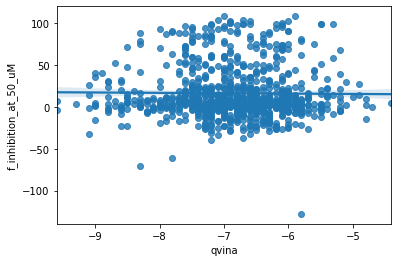

In [24]:
from scipy.stats import spearmanr

tmp = data.dropna(subset=['qvina', 'f_inhibition_at_50_uM'])
print(f"Spearman R: {spearmanr(tmp['qvina'], tmp['f_inhibition_at_50_uM'])[1]}")
del tmp

sns.regplot(data=data, x='qvina', y='f_inhibition_at_50_uM', )
plt.savefig('regplot_qvina.png', dpi=128)

<a id='qq_plot'></a>
### QQ Plot

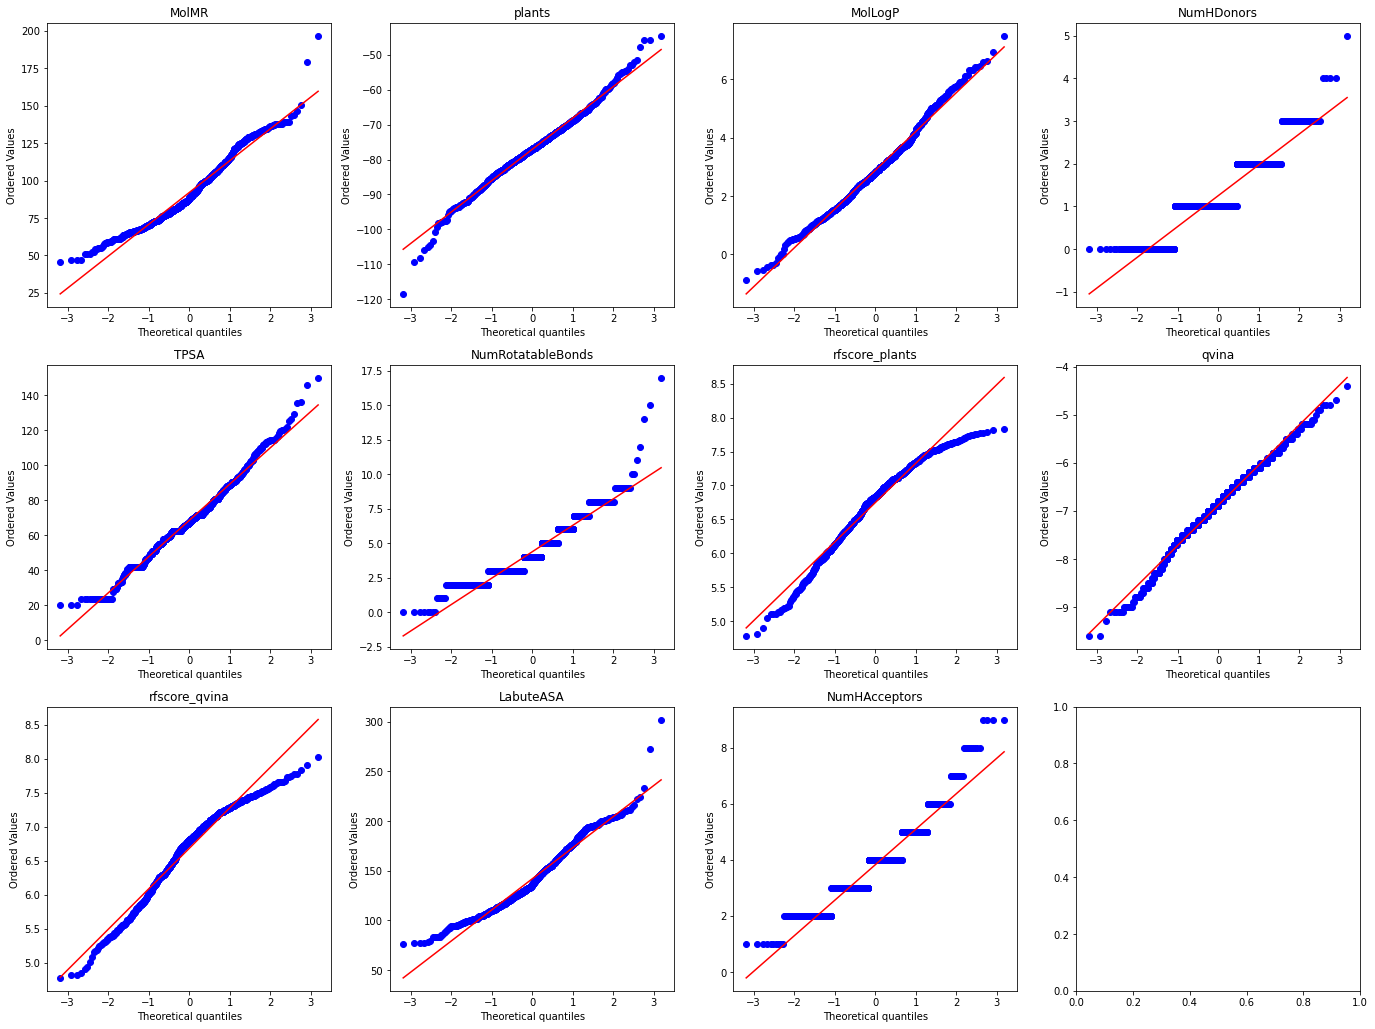

In [25]:
def qq_plot(X):
    from scipy.stats import probplot

    ncol = 4
    nrow = int(np.ceil(len(X.columns) / ncol))
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 4.8, nrow * 4.8))
    for i, x in enumerate(X.columns):
        probplot(data[x], dist='norm', plot=ax[i%nrow, i%ncol])
        ax[i%nrow, i%ncol].set_title(x)

    fig.tight_layout()
    plt.show()

qq_plot(data[trainset])

In [26]:
# Read data
data = pd.read_csv('data.csv')

# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Descriptors
descriptors_list = list(descriptors.columns[1:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']
trainset = descriptors_list + docking_list

# Test metrics
scoring_metrics = ['accuracy','precision','recall','f1','f2','geometric_mean','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]
columns = [*test_metrics, 'activity_label', 'model', 'random_state'] + trainset

In [27]:
# Read test scores and sort values
local = False
if local:
    # Local computer
    scores_data = pd.read_csv('scores_data.csv')
else:
    # Cluster results
    scores_data = pd.read_csv('scores_data_cluster.csv.gz', compression='gzip')
    # Groupby "job_id" and get mean of random states (https://stackoverflow.com/a/65028508/13131079)
    d = {True: 'mean', False: 'first'}
    agg_map = {col: d[pd.api.types.is_numeric_dtype(i)] for col, i in zip(
        scores_data.columns, scores_data.dtypes)}
    scores_data = scores_data.groupby('job_id').agg(agg_map).drop(
        ['job_id','random_state'], axis=1).reset_index(drop=True)
    
columns = scores_data.columns
selected = ['test_f2', 'test_geometric_mean', 'test_roc_auc']

# Scale results
#scores_data[test_metrics] = StandardScaler().fit_transform(scores_data[test_metrics])
scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.head()

,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_geometric_mean,test_roc_auc,activity_label,model,MolMR,...,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
9249,0.726683,0.283225,0.625213,0.389171,0.502656,0.680573,0.684129,f_active,KNeighborsClassifier,0,...,1,1,0,0,1,1,1,0,0,0.622453
4990,0.708826,0.277853,0.638086,0.386694,0.506076,0.676698,0.679400,r_active,LinearDiscriminantAnalysis,0,...,1,1,1,0,0,0,0,1,0,0.620725
5004,0.708826,0.277853,0.638086,0.386694,0.506076,0.676698,0.679400,r_active,LinearDiscriminantAnalysis,0,...,1,1,0,1,0,0,0,1,0,0.620725
6174,0.742996,0.302922,0.601216,0.401739,0.500927,0.676817,0.684034,r_active,LogisticRegression,0,...,1,1,1,1,1,0,0,1,1,0.620593
6082,0.710312,0.278607,0.636173,0.386983,0.505492,0.676427,0.679470,r_active,LinearDiscriminantAnalysis,0,...,1,1,1,1,0,0,0,1,1,0.620463


In [28]:
# Dictionary: key == model_name, value == list of best descriptors
best_subset = {}

activity_label = 'f_active'
for i, row in scores_data.query('activity_label == @activity_label').groupby('model').head(1).iterrows():
    best_subset[row['model']] = [descriptor for descriptor in trainset if row[descriptor]]

In [29]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, log_loss

model_name = 'XGBClassifier'
subset = best_subset[model_name]

y = data[activity_label]
X = data[subset]

scaler = StandardScaler()
t0 = time.time()
pipe = make_pipeline(SMOTE(random_state=42), scaler, XGBClassifier(objective='reg:logistic', random_state=13))

scoring_metrics = ['test_f2','test_geometric_mean','test_roc_auc','train_f2','train_geometric_mean','train_roc_auc']
metrics_dict = {key: [] for key in scoring_metrics}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y): 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    model_fitted = pipe.fit(X_train, y_train)

    # Test predictions
    y_pred = model_fitted.predict(X_test)
    metrics_dict['test_f2'].append(fbeta_score(y_test, y_pred, beta=2)) # test_f2
    metrics_dict['test_geometric_mean'].append(geometric_mean_score(y_test, y_pred)) # test_geometric_mean
    metrics_dict['test_roc_auc'].append(roc_auc_score(y_test, y_pred)) # test_roc_auc

    # Training predictions
    y_pred = model_fitted.predict(X_train)
    metrics_dict['train_f2'].append(fbeta_score(y_train, y_pred, beta=2)) # train_f2
    metrics_dict['train_geometric_mean'].append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
    metrics_dict['train_roc_auc'].append(roc_auc_score(y_train, y_pred)) # train_roc_auc
    
pipe = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

t1 = time.time()
print('{:g}m:{:g}s'.format(*divmod(t1 - t0, 60)))

#     Predicted   inactive |  active
# Actual 
# inactive      |    TN    |    FP    | 
# active        |    FN    |    TP    | 

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
matrix = pd.DataFrame(conf_matrix)

print(model_name)
print(f'RMSE: {np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test)):.4f}')
print(f'log_loss: {log_loss(y_test, y_proba):.4f}')
matrix

0m:1.04974s
XGBClassifier
RMSE: 0.3980
log_loss: 0.5280


,0,1
0,0.839506,0.160494
1,0.653846,0.346154


In [30]:
from sklearn.naive_bayes import GaussianNB

model_list = [GaussianNB()]

# Probabilities for the top models
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# List of scores for the top models
scores_list = []
new_data = data.dropna(subset=trainset)

model_name = 'LogisticRegression'
subset = best_subset[model_name]

count = 0
for i, model in enumerate(model_list):
    num = i
    y = new_data[activity_label]
    X = new_data[subset]
    
    activity_label = 'f_active'
    scaler = StandardScaler()
    pipe = make_pipeline(SMOTE(random_state=42), scaler, model)
        
    metrics_dict = {key: [] for key in scoring_metrics}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        
        # Test predictions
        y_pred = model_fitted.predict(X_test)
        metrics_dict['test_f2'].append(fbeta_score(y_test, y_pred, beta=2)) # test_f2
        metrics_dict['test_geometric_mean'].append(geometric_mean_score(y_test, y_pred)) # test_geometric_mean
        metrics_dict['test_roc_auc'].append(roc_auc_score(y_test, y_pred)) # test_roc_auc
        
        # Training predictions
        y_pred = model_fitted.predict(X_train)
        metrics_dict['train_f2'].append(fbeta_score(y_train, y_pred, beta=2)) # train_f2
        metrics_dict['train_geometric_mean'].append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
        metrics_dict['train_roc_auc'].append(roc_auc_score(y_train, y_pred)) # train_roc_auc
    
    # Mean of the KFold scores
    scores = [np.mean(value) for value in metrics_dict.values()]
    scores_list.append([num, *scores])
    
    count+=1

columns = ['model', *scoring_metrics]
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[scoring_metrics[:3]].mean(axis=1)
top_scores['train_mean'] = top_scores[scoring_metrics[3:]].mean(axis=1)
top_scores

,model,test_f2,test_geometric_mean,test_roc_auc,train_f2,train_geometric_mean,train_roc_auc,test_mean,train_mean
0,0,0.424653,0.601658,0.606786,0.443113,0.620054,0.620305,0.544366,0.561157


KeyError: 'KNeighborsClassifier'

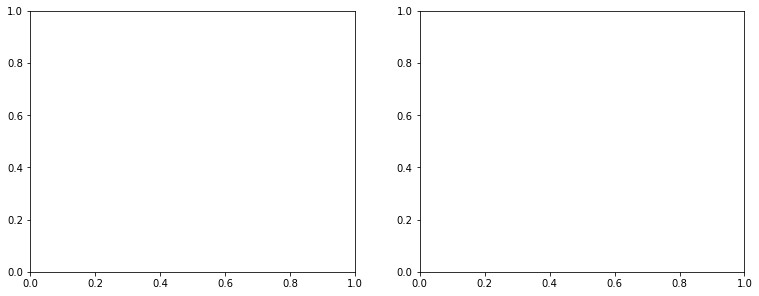

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))

# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[0].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[1].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(2):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Train data')
ax[1].legend(title='Test data')

plt.suptitle('Receiver Operating Characteristic')
#plt.savefig('test_roc_curve.png', dpi=216)

# CONFERIR GRAFICO DO VINA

top_scores